In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
import shap

## Dataset

In [ ]:
# --- Carregamento ---#

data_df = pd.read_csv('Merged01.csv')

print(data_df.shape)
data_df.head()

(712311, 40)


,Header_Length,Protocol Type,Time_To_Live,Rate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,...,Tot sum,Min,Max,AVG,Std,Tot size,IAT,Number,Variance,Label
0,19.92,6,63.36,25893.962218,0.0,0.0,0.0,0.99,0.99,0.0,...,6421,60,481,64.21,42.100000,64.21,0.000039,100,1772.410000,DDOS-PSHACK_FLOOD
1,0.00,47,64.00,3703.841331,0.0,0.0,0.0,0.00,0.00,0.0,...,57320,98,578,573.20,48.000000,573.20,0.000271,100,2304.000000,MIRAI-GREIP_FLOOD
2,7.92,17,65.91,19673.095685,0.0,0.0,0.0,0.00,0.00,0.0,...,6010,60,70,60.10,1.000000,60.10,0.000057,100,1.000000,DOS-UDP_FLOOD
3,20.40,6,110.50,261.664826,0.1,0.0,0.3,0.20,0.40,0.0,...,2223,54,1500,222.30,451.596686,222.30,0.004766,10,203939.566667,DNS_SPOOFING
4,0.32,1,63.96,28944.199848,0.0,0.0,0.0,0.00,0.01,0.0,...,6006,60,66,60.06,0.600000,60.06,0.000035,100,0.360000,DDOS-ICMP_FLOOD


In [ ]:
# --- Filtrar e remover colunas com inf --- #

# Criar uma cópia apenas com colunas numéricas
num_df = data_df.select_dtypes(include=[np.number])

# Criar máscara de infinitos (somente nas colunas numéricas)
inf_mask = num_df.map(np.isinf)

# Filtrar colunas que têm pelo menos um valor infinito
colunas_com_inf = inf_mask.any()

print("Colunas com valores infinitos:")
print(colunas_com_inf[colunas_com_inf].index.tolist())

# Remove linhas que tenham algum infinito
data_df = data_df[~inf_mask.any(axis=1)]

print("Número de linhas após remover infinitos em 'Rate':", data_df.shape[0])
print("Número de colunas:", data_df.shape[1])

Colunas com valores infinitos:
['Rate']
Número de linhas após remover infinitos em 'Rate': 712297
Número de colunas: 40


In [ ]:
attack_class_mapping = {
    # Benigno
    'BENIGN': 'Benign',

    # DDoS
    'DDOS-PSHACK_FLOOD': 'Attack',
    'DDOS-ICMP_FLOOD': 'Attack',
    'DDOS-TCP_FLOOD': 'Attack',
    'DDOS-SYN_FLOOD': 'Attack',
    'DDOS-UDP_FLOOD': 'Attack',
    'DDOS-SYNONYMOUSIP_FLOOD': 'Attack',
    'DDOS-RSTFINFLOOD': 'Attack',
    'DDOS-SLOWLORIS': 'Attack',
    'DDOS-ICMP_FRAGMENTATION': 'Attack',
    'DDOS-ACK_FRAGMENTATION': 'Attack',
    'DDOS-UDP_FRAGMENTATION': 'Attack',
    'DDOS-HTTP_FLOOD': 'Attack',

    # DoS
    'DOS-UDP_FLOOD': 'Attack',
    'DOS-TCP_FLOOD': 'Attack',
    'DOS-SYN_FLOOD': 'Attack',
    'DOS-HTTP_FLOOD': 'Attack',

    # Recon
    'RECON-HOSTDISCOVERY': 'Attack',
    'VULNERABILITYSCAN': 'Attack',
    'RECON-PORTSCAN': 'Attack',
    'RECON-OSSCAN': 'Attack',
    'RECON-PINGSWEEP': 'Attack'

}

attack_class_to_num = {
    'Benign': 0,
    'Attack': 1
}

(664743, 42)
Distribuição de classes (absoluta)
Attack_Class
1    648169
0     16574
Name: count, dtype: int64
Distribuição de classes (percentual)
Attack_Class
1    97.506706
0     2.493294
Name: proportion, dtype: float64


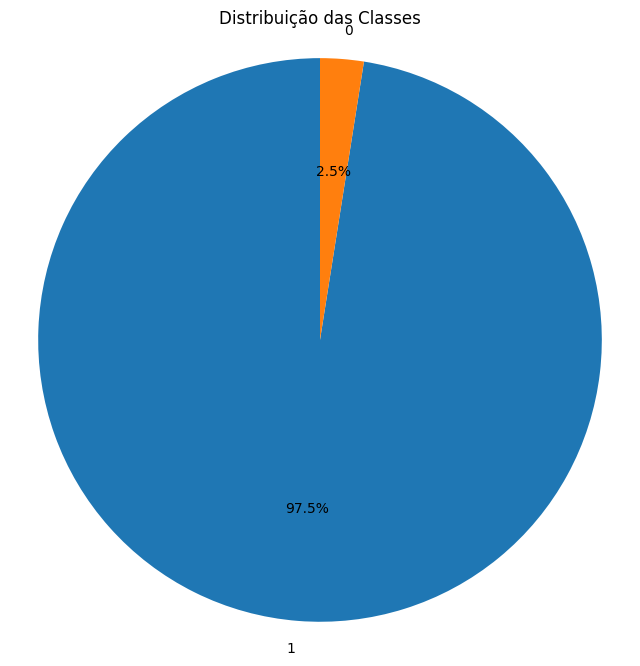

In [ ]:
# --- Mapeamento e filtragem de classes --- #

# Manter apenas classes presentes no mapping
data_df = data_df[data_df["Label"].isin(attack_class_mapping.keys())].copy()

# Aplicar o mapping (nome → número)
data_df['Attack_Type'] = data_df['Label'].map(attack_class_mapping)
data_df['Attack_Class'] = data_df['Attack_Type'].map(attack_class_to_num)

print(data_df.shape)
print("Distribuição de classes (absoluta)")
print(data_df['Attack_Class'].value_counts())
print("Distribuição de classes (percentual)")
print(data_df['Attack_Class'].value_counts(normalize=True) * 100)

# Gráfico
class_counts = data_df['Attack_Class'].value_counts()
labels =  class_counts.index
sizes = class_counts.values

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Distribuição das Classes')
plt.axis('equal')  # deixa o círculo redondo
plt.show()

## Treinamento

In [ ]:
# --- Mapeamento e filtragem de classes --- #

# Separar X e y
X = data_df.drop(columns=['Label', 'Attack_Type', 'Attack_Class'])
y = data_df['Attack_Class']                 # coluna alvo

# 1º Split: Treino + Temp (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# 2º Split: Validação e Teste
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Converter para DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dval   = xgb.DMatrix(X_val, label=y_val)
dtest  = xgb.DMatrix(X_test, label=y_test)

# Resultado
print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)

Train: (465320, 39)
Val: (99711, 39)
Test: (99712, 39)


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 11.0 MB/s eta 0:00:00


In [ ]:
#--- Criação dos clientes FL ---#

# Variáveis globais para a simulação FL (definidas no código anterior)
num_clients = 4
num_boost_round = 50
rounds_per_client = 5

# Divisão do conjunto de treino em 4 clientes (silos de dados)
# Certifique-se de que X_train e y_train já estão definidos pelas células anteriores
X_train_clients = np.array_split(X_train, num_clients)
y_train_clients = np.array_split(y_train, num_clients)
dtrain_clients = []

for i in range(num_clients):
    dtrain_clients.append(xgb.DMatrix(X_train_clients[i], label=y_train_clients[i]))

print("Preparação dos dados dos clientes concluída para Optuna.")
# dval é o conjunto de validação global

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


Preparação dos dados dos clientes concluída para Optuna.


In [ ]:
#--- Otimização de hiperparâmetros com Optuna ---#

# Importar Optuna
import optuna

def objective(trial):
    # 1. Sugestão de Hiperparâmetros
    params = {
        'objective': 'multi:softprob',
        'num_class': len(attack_class_to_num),
        'eval_metric': 'mlogloss',
        'verbosity': 0,

        # Parâmetros de Optimização
        'eta': trial.suggest_float('eta', 0.01, 0.3),                 # Learning Rate
        'max_depth': trial.suggest_int('max_depth', 6, 12),           # Profundidade máxima da árvore
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),     # Amostra de linhas para construir a árvore
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0), # Amostra de colunas para construir a árvore
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),  # Regularização L2
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True)    # Regularização L1
    }

    # 2. Inicialização do Modelo Global
    global_model = None

    # 3. Simulação do Treinamento Federado

    # Rodadas Globais totais
    num_global_rounds = int(num_boost_round / rounds_per_client)

    for global_round in range(num_global_rounds):

        for i in range(num_clients):
            dclient = dtrain_clients[i]

            # Treinamento Local: Continua o treinamento a partir do modelo global
            local_model = xgb.train(
                params,
                dclient,
                num_boost_round=rounds_per_client,
                xgb_model=global_model,
                evals=[],
                verbose_eval=False
            )

            # Atualização do Modelo Global (Simulação de Agregação)
            global_model = local_model

        # Callback para Optuna: Permite Early Stopping do trial
        # Avaliamos o modelo global no conjunto de validação
        eval_mlogloss_val = global_model.eval(dval, 'val_eval').split('\t')[1].split(':')[1]
        loss_val = float(eval_mlogloss_val)

        trial.report(loss_val, global_round)

        # Early Stopping para o Optuna (se a perda começar a subir significativamente)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # 4. Retorna a métrica final de validação (mlogloss)
    return loss_val

# 5. Execução do Estudo Optuna
# Minimize a mlogloss (direção 'minimize')
study = optuna.create_study(direction='minimize')

# Executa 100 tentativas (você pode aumentar este número para maior precisão)
study.optimize(objective, n_trials=50, show_progress_bar=True)

# Resultados
print("\n--- Resultados do Optuna ---")
print(f"Melhor mlogloss de validação: {study.best_value:.4f}")
print("Melhores Parâmetros:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2025-11-28 22:41:55,984] A new study created in memory with name: no-name-17768208-98fa-41cf-88e7-c94289657863


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-11-28 22:42:56,947] Trial 0 finished with value: 0.01942224187425796 and parameters: {'eta': 0.18408501842307934, 'max_depth': 10, 'subsample': 0.6336828509738439, 'colsample_bytree': 0.8706324925256141, 'lambda': 0.006261911082050296, 'alpha': 0.00014129039334266516}. Best is trial 0 with value: 0.01942224187425796.
[I 2025-11-28 22:43:32,131] Trial 1 finished with value: 0.01704589838914343 and parameters: {'eta': 0.23894096626520084, 'max_depth': 6, 'subsample': 0.9529140664189089, 'colsample_bytree': 0.893823799694526, 'lambda': 0.0001706190087221387, 'alpha': 0.010723099104746697}. Best is trial 1 with value: 0.01704589838914343.
[I 2025-11-28 22:44:18,164] Trial 2 finished with value: 0.01928361168297996 and parameters: {'eta': 0.15033501040383274, 'max_depth': 11, 'subsample': 0.6187894979039558, 'colsample_bytree': 0.96528049722376, 'lambda': 0.007347365526880618, 'alpha': 0.00012531807287490852}. Best is trial 1 with value: 0.01704589838914343.
[I 2025-11-28 22:44:54,9

In [ ]:
#--- Treinamento com os melhores parâmetros ---#

# Recuperar os melhores parâmetros
best_params = study.best_params

# Adicionar os parâmetros fixos
best_params.update({
    'objective': 'multi:softprob',
    'num_class': len(attack_class_to_num),
    'eval_metric': 'mlogloss',
    'verbosity': 1
})

# Repetição do Treinamento Federado Final (para capturar o logloss para o plot)

final_global_model = None
evals_result_final = {'train': {'mlogloss': []}, 'val': {'mlogloss': []}}
num_global_rounds = int(num_boost_round / rounds_per_client)

print("\n--- Treinando Modelo Global Final com os Melhores Parâmetros ---")

for global_round in range(num_global_rounds):

    for i in range(num_clients):
        dclient = dtrain_clients[i]

        local_model = xgb.train(
            best_params,
            dclient,
            num_boost_round=rounds_per_client,
            xgb_model=final_global_model,
            evals=[(dclient, 'local_train')],
            verbose_eval=False
        )

        final_global_model = local_model

    # Avaliação e armazenamento para o plot
    eval_mlogloss_val = final_global_model.eval(dval, 'val_eval').split('\t')[1].split(':')[1]
    eval_mlogloss_train = final_global_model.eval(dtrain_clients[0], 'train_eval').split('\t')[1].split(':')[1]

    evals_result_final['train']['mlogloss'].extend([float(eval_mlogloss_train)] * rounds_per_client)
    evals_result_final['val']['mlogloss'].extend([float(eval_mlogloss_val)] * rounds_per_client)

print("\n✅ Treinamento Federado Final Concluído.")


--- Treinando Modelo Global Final com os Melhores Parâmetros ---

✅ Treinamento Federado Final Concluído.


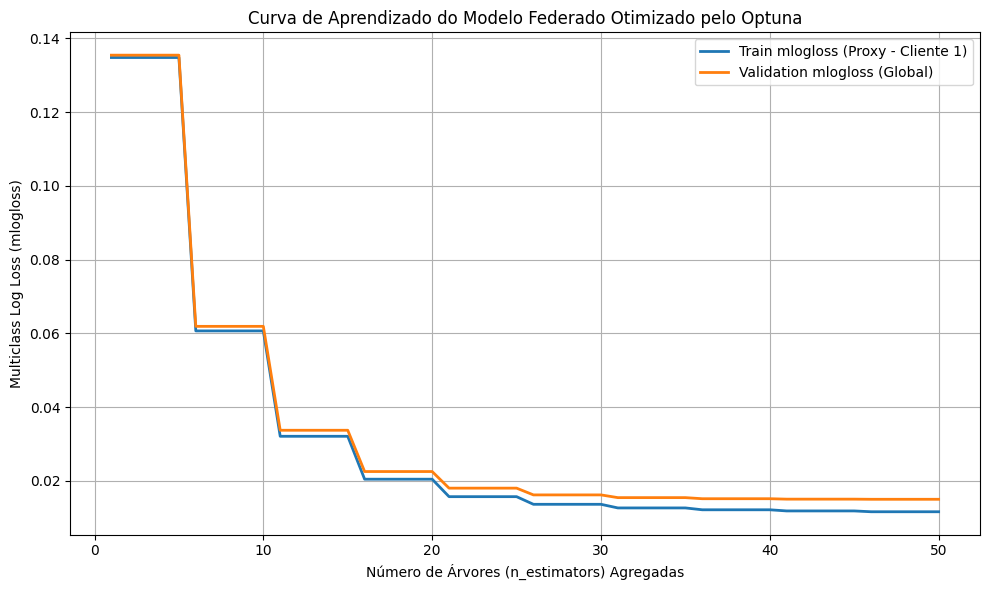

In [ ]:
# --- Plotar mlogloss vs n_estimators (Modelo Otimizado) ---#

# Usa os resultados armazenados do treinamento final com Optuna
total_rounds = len(evals_result_final['val']['mlogloss'])
rounds = list(range(1, total_rounds + 1))

plt.figure(figsize=(10, 6))

# Nota: 'train' é um proxy (Cliente 1), 'val' é a avaliação do Servidor Global
plt.plot(rounds, evals_result_final['train']['mlogloss'], label='Train mlogloss (Proxy - Cliente 1)', linewidth=2)
plt.plot(rounds, evals_result_final['val']['mlogloss'], label='Validation mlogloss (Global)', linewidth=2)
plt.xlabel('Número de Árvores (n_estimators) Agregadas')
plt.ylabel('Multiclass Log Loss (mlogloss)')
plt.title('Curva de Aprendizado do Modelo Federado Otimizado pelo Optuna')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Resultados


--- Avaliação Final do Modelo Global Otimizado ---
📊 Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.88      0.86      2486
         1.0       1.00      1.00      1.00     97226

    accuracy                           0.99     99712
   macro avg       0.93      0.94      0.93     99712
weighted avg       0.99      0.99      0.99     99712

✅ Accuracy: 0.9931703305519898


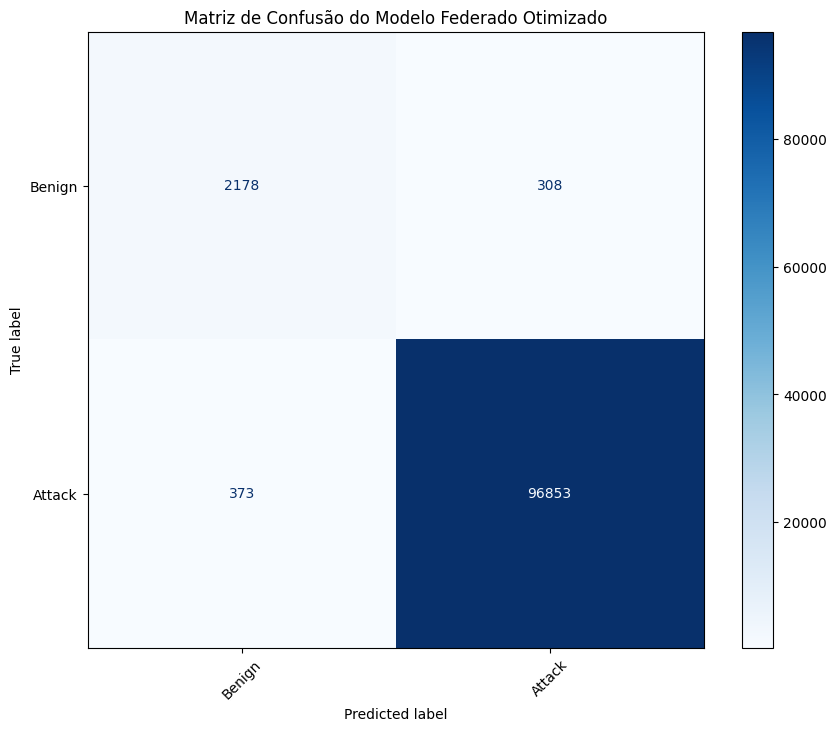

In [ ]:
# --- Relatório de métricas e matriz de confusão --- #

# Previsões em forma de probabilidade, usando o modelo final Otimizado
y_pred_prob = final_global_model.predict(dtest)

# Converter para rótulos (classe com maior probabilidade)
y_pred = np.argmax(y_pred_prob, axis=1)

# Valores reais do conjunto de teste
y_true = dtest.get_label()

print("\n--- Avaliação Final do Modelo Global Otimizado ---")
print("📊 Classification Report:")

# Gera o relatório de classificação
print(classification_report(y_true, y_pred))

print("✅ Accuracy:", accuracy_score(y_true, y_pred))

# --- Matriz de Confusão ---

# Nomes das classes para exibição na Matriz de Confusão
class_names = list(attack_class_to_num.keys())

# Gerar a matriz de confusão
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plotar a imagem
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(cmap='Blues', xticks_rotation=45, ax=ax)
plt.title('Matriz de Confusão do Modelo Federado Otimizado')
plt.show()

            feature  importance
34           Number  423.910217
0     Header_Length    9.467940
12        syn_count    9.246145
5   syn_flag_number    6.244608
16            HTTPS    5.494283
33              IAT    4.965214
13        fin_count    3.786613
4   fin_flag_number    3.723775
6   rst_flag_number    3.003026
9   ece_flag_number    2.790433
32         Tot size    2.773309
30              AVG    2.713767
11        ack_count    2.682258
14        rst_count    2.502226
10  cwr_flag_number    1.963437
29              Max    1.886609
35         Variance    1.772653
22             DHCP    1.747761
15             HTTP    1.744214
8   ack_flag_number    1.707129
24             ICMP    1.645103
31              Std    1.628735
3              Rate    1.626612
7   psh_flag_number    1.603027
2      Time_To_Live    1.600091
17              DNS    1.598240
18              SSH    1.562931
21              UDP    1.520637
28              Min    1.455030
23              ARP    1.439161
26      

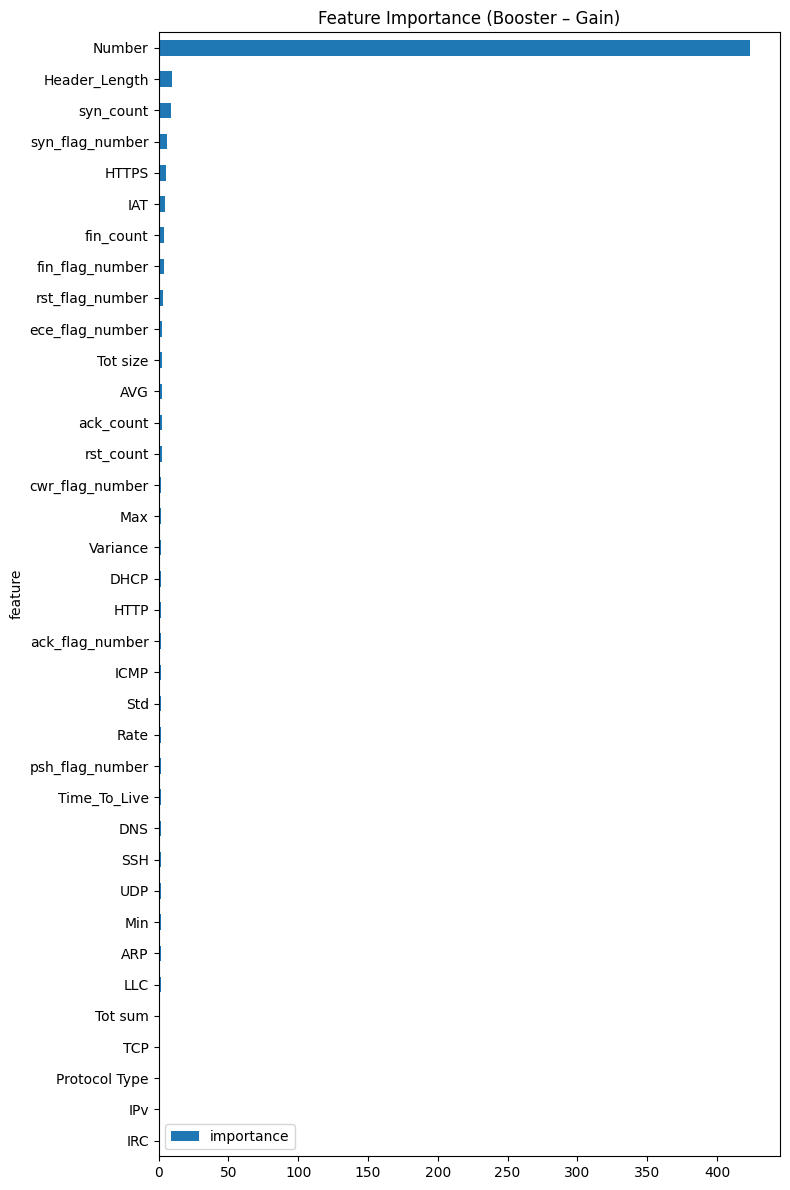

In [ ]:
# --- Importância das features no modelo XGBoost --- #

# Calcula importância por ganho
booster = final_global_model
score = booster.get_score(importance_type='gain')

booster_features = list(score.keys())
original_features = list(X_train.columns)

# Mapeamento seguro
feature_map = {}
for f in booster_features:
    try:
        idx = int(f[1:])
        if idx < len(original_features):
            feature_map[f] = original_features[idx]
        else:
            feature_map[f] = f"unknown_{idx}"
    except:
        feature_map[f] = f

# Construir DataFrame final
feature_importance = (
    pd.DataFrame(score.items(), columns=['feature', 'importance'])
      .assign(feature=lambda df: df['feature'].map(feature_map))
      .sort_values('importance', ascending=False)
)

print(feature_importance)

# Plot
feature_importance.sort_values("importance").plot(
    x="feature", y="importance", kind="barh", figsize=(8,12)
)
plt.title("Feature Importance (Booster – Gain)")
plt.tight_layout()
plt.show()
